In [2]:
import pandas as pd  # Used for data manipulation and analysis, primarily for DataFrames.
import seaborn as sns  # A high-level library for drawing attractive statistical graphics.
import matplotlib.pyplot as plt # A comprehensive library for creating static, animated, and interactive visualizations in Python.
import numpy as np  # Needed for numerical operations and array handling.

In [3]:
print("--- Step 1: Loading and Preprocessing Data ---")
dataset = pd.read_csv('Extracted-dataset.csv')
dataset.head()

--- Step 1: Loading and Preprocessing Data ---


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2009-01-01,NorfolkIsland,20.4,25.8,0.0,6.0,12.4,NNW,31.0,NNW,...,71.0,1014.5,1013.6,3.0,1.0,23.3,24.7,No,0.2,No
1,2009-01-02,NorfolkIsland,20.9,26.7,0.2,8.0,10.3,N,31.0,NNE,...,77.0,1016.3,1015.5,2.0,5.0,25.0,25.1,No,0.0,No
2,2009-01-03,NorfolkIsland,22.3,26.3,0.0,3.2,2.0,E,35.0,ENE,...,90.0,1014.6,1014.3,7.0,7.0,24.7,23.8,No,1.2,Yes
3,2009-01-04,NorfolkIsland,21.6,22.2,1.2,2.8,0.0,ESE,41.0,ESE,...,95.0,1016.0,1015.3,8.0,8.0,22.1,21.2,Yes,2.6,Yes
4,2009-01-05,NorfolkIsland,20.4,23.5,2.6,2.2,2.9,ESE,52.0,ESE,...,86.0,1015.3,1013.7,7.0,7.0,21.8,21.6,Yes,0.0,No


In [4]:
print("Original Dataset Shape:", dataset.shape)

# --- STEP 1.1: Encode binary target/label columns ---
# Convert the 'Yes'/'No' string labels in 'RainToday' and 'RainTomorrow' to 1/0 for model training.
dataset['RainToday'] = dataset['RainToday'].map({'No': 0, 'Yes': 1})
dataset['RainTomorrow'] = dataset['RainTomorrow'].map({'No': 0, 'Yes': 1})

Original Dataset Shape: (121575, 24)


In [5]:
# Check for columns that are entirely empty.
fully_missing_cols = dataset.columns[dataset.isnull().all()]
print("Columns with all missing values:", fully_missing_cols.tolist())

Columns with all missing values: []


In [6]:
# --- Step 2: Handling Missing Values ---
print("--- Step 2: Handling Missing Values ---")

# Separate columns into categorical (object) and numerical (float/int).
categorical_cols = dataset.select_dtypes(include=['object']).columns
numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
columns_to_impute = [col for col in dataset.columns if col not in ['Date', 'Location']]   


--- Step 2: Handling Missing Values ---


In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Step 2.1: Impute categorical columns with mode
# Iterate through each categorical column.
for col in categorical_cols:
    # Find the most frequent value (mode) in the column.
    mode_value = dataset[col].mode()[0]
    print(f"Imputing missing values in column '{col}' with mode value: '{mode_value}'")
    # Fill any missing values (NaN) with the calculated mode.
    dataset[col] = dataset[col].fillna(mode_value)

# Step 2.2: Label Encode categorical columns
print("Label encoding categorical columns...")
lencoders = {}  # Create an empty dictionary to store each LabelEncoder instance, so that we can inverse transform later if needed.
                # Iterate through each categorical column again.       


for col in categorical_cols:
    lencoders[col] = LabelEncoder()  # Create a new LabelEncoder for the column.
    # Fit the encoder on the data and transform the column.
    dataset[col] = lencoders[col].fit_transform(dataset[col])

Imputing missing values in column 'Date' with mode value: '2013-03-02'
Imputing missing values in column 'Location' with mode value: 'Canberra'
Imputing missing values in column 'WindGustDir' with mode value: 'W'
Imputing missing values in column 'WindDir9am' with mode value: 'N'
Imputing missing values in column 'WindDir3pm' with mode value: 'W'
Label encoding categorical columns...


In [8]:
# Prepare a copy of the data for MICE imputation, excluding 'Date' and 'Location' as they are not needed for this process.
dataset_for_mice = dataset[columns_to_impute].copy()

# Step 2.3: Impute numerical columns using Iterative Imputer (MICE)
print("Running MICE imputation on numerical features...")
# Initialize the MICE imputer with a max_iter and random_state for reproducibility.
mice_imputer = IterativeImputer(max_iter=50, random_state=42)
# Fit the imputer on the data and transform it. This returns a NumPy array.
dataset_imputed_array = mice_imputer.fit_transform(dataset_for_mice)
# Convert the imputed array back into a pandas DataFrame, preserving the column names.
dataset_imputed = pd.DataFrame(dataset_imputed_array, columns=dataset_for_mice.columns)

print("Shape after imputation:", dataset_imputed.shape)
dataset_imputed.head(6)

Running MICE imputation on numerical features...
Shape after imputation: (121575, 22)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,20.4,25.8,0.0,6.0,12.4,6.0,31.0,6.0,7.0,13.0,...,71.0,1014.5,1013.6,3.0,1.0,23.3,24.7,0.0,0.2,0.0
1,20.9,26.7,0.2,8.0,10.3,3.0,31.0,5.0,4.0,15.0,...,77.0,1016.3,1015.5,2.0,5.0,25.0,25.1,0.0,0.0,0.0
2,22.3,26.3,0.0,3.2,2.0,0.0,35.0,1.0,9.0,6.0,...,90.0,1014.6,1014.3,7.0,7.0,24.7,23.8,0.0,1.2,1.0
3,21.6,22.2,1.2,2.8,0.0,2.0,41.0,2.0,2.0,20.0,...,95.0,1016.0,1015.3,8.0,8.0,22.1,21.2,1.0,2.6,1.0
4,20.4,23.5,2.6,2.2,2.9,2.0,52.0,2.0,2.0,24.0,...,86.0,1015.3,1013.7,7.0,7.0,21.8,21.6,1.0,0.0,0.0
5,20.4,24.4,0.0,3.0,8.7,0.0,48.0,2.0,2.0,30.0,...,79.0,1014.5,1012.7,5.0,3.0,21.4,23.3,0.0,0.0,0.0


In [9]:
# --- Step 3: Exploratory Data Analysis (EDA) ---
# Step 1: Keep only numeric columns (needed for Pearson correlation)
numeric_df = dataset_imputed.select_dtypes(include=['float64', 'int64'])

# Step 2: Get correlation of each numeric column with 'RainTomorrow'
correlation_with_target = numeric_df.corr()['RainTomorrow'].sort_values(ascending=False)

# Step 3: Print correlation values
print("\n--- Pearson Correlation with 'RainTomorrow' ---")
print(correlation_with_target)


--- Pearson Correlation with 'RainTomorrow' ---
RainTomorrow     1.000000
RISK_MM          0.502849
Humidity3pm      0.445446
Cloud3pm         0.424212
Cloud9am         0.346735
RainToday        0.315456
Humidity9am      0.254320
Rainfall         0.243046
WindGustSpeed    0.235903
WindSpeed9am     0.091954
WindSpeed3pm     0.090435
MinTemp          0.073298
WindGustDir      0.062669
WindDir3pm       0.042008
WindDir9am       0.036469
Temp9am         -0.033767
Evaporation     -0.139542
MaxTemp         -0.163818
Temp3pm         -0.197179
Pressure3pm     -0.244901
Pressure9am     -0.265401
Sunshine        -0.480424
Name: RainTomorrow, dtype: float64


<Axes: ylabel='None'>

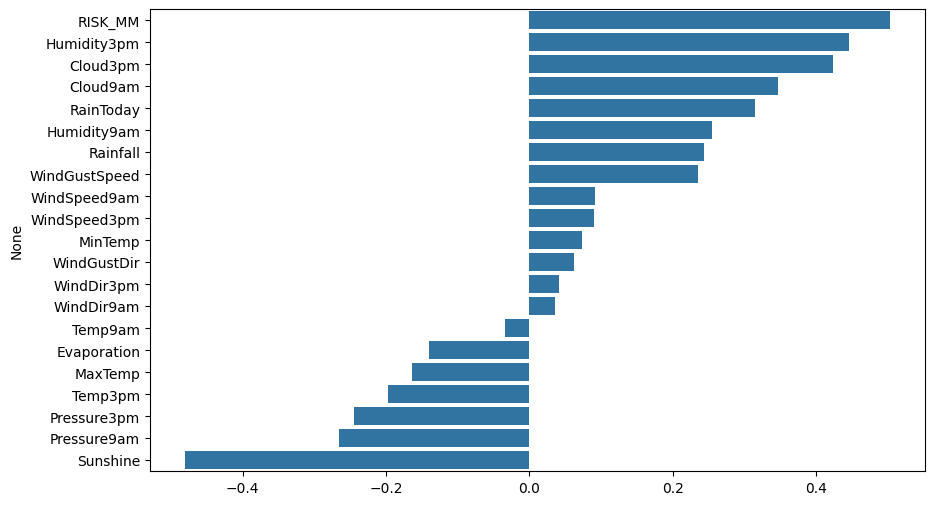

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=correlation_with_target.drop('RainTomorrow').values,
    y=correlation_with_target.drop('RainTomorrow').index
)

In [11]:
# --- Step 4: Preparing Data for Modeling ---

from sklearn.model_selection import train_test_split 

# Make a copy of the imputed dataset.
data = dataset_imputed.copy()

# Remove 'RISK_MM' to prevent data leakage.
if 'RISK_MM' in data.columns:
    data.drop('RISK_MM', axis=1, inplace=True)
    print("'RISK_MM' feature removed to prevent data leakage.")
else:
    print("'RISK_MM' already removed or not present.")

print("\nUpdated dataset shape:", data.shape)
print("\nFirst 5 rows after removing 'RISK_MM':")
data.head()


'RISK_MM' feature removed to prevent data leakage.

Updated dataset shape: (121575, 21)

First 5 rows after removing 'RISK_MM':


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,20.4,25.8,0.0,6.0,12.4,6.0,31.0,6.0,7.0,13.0,...,84.0,71.0,1014.5,1013.6,3.0,1.0,23.3,24.7,0.0,0.0
1,20.9,26.7,0.2,8.0,10.3,3.0,31.0,5.0,4.0,15.0,...,79.0,77.0,1016.3,1015.5,2.0,5.0,25.0,25.1,0.0,0.0
2,22.3,26.3,0.0,3.2,2.0,0.0,35.0,1.0,9.0,6.0,...,87.0,90.0,1014.6,1014.3,7.0,7.0,24.7,23.8,0.0,1.0
3,21.6,22.2,1.2,2.8,0.0,2.0,41.0,2.0,2.0,20.0,...,92.0,95.0,1016.0,1015.3,8.0,8.0,22.1,21.2,1.0,1.0
4,20.4,23.5,2.6,2.2,2.9,2.0,52.0,2.0,2.0,24.0,...,86.0,86.0,1015.3,1013.7,7.0,7.0,21.8,21.6,1.0,0.0


In [12]:
# Define features (X) and target (y).
X = data.drop('RainTomorrow', axis=1)  # All columns except the target.
y = data['RainTomorrow']  # The target variable.

# Split the data into training (70%) and testing (30%) sets.
# `stratify=y` ensures that the class distribution is maintained in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Standardize the numerical features.         improve training speed and stability, and to make sure all features contribute fairly to a machine learning model 
scaler = StandardScaler()
# Fit the scaler on the training data and transform it.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# Use the *same* scaler to transform the test data. Do not fit again.
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Training Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("Testing Set Class Distribution:\n", y_test.value_counts(normalize=True))

Original Class Distribution:
 RainTomorrow
0.0    0.773901
1.0    0.226099
Name: proportion, dtype: float64
Training Set Class Distribution:
 RainTomorrow
0.0    0.773907
1.0    0.226093
Name: proportion, dtype: float64
Testing Set Class Distribution:
 RainTomorrow
0.0    0.773888
1.0    0.226112
Name: proportion, dtype: float64


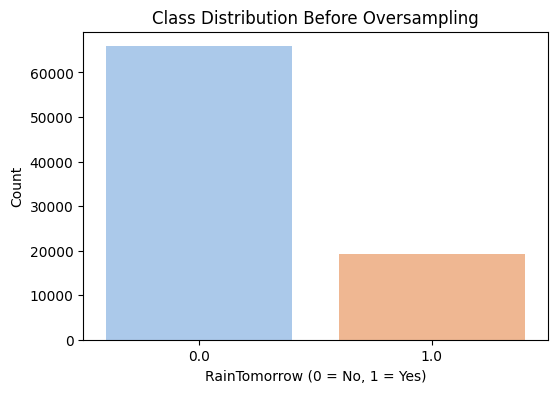

In [13]:
# Plot class distribution in original training data

# Make sure y_train is a DataFrame with column name

y_train_df = pd.DataFrame(y_train, columns=['RainTomorrow'])

plt.figure(figsize=(6, 4))
sns.countplot(data=y_train_df, x='RainTomorrow', hue='RainTomorrow', palette='pastel', legend=False)
plt.title("Class Distribution Before Oversampling")
plt.xlabel("RainTomorrow (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


--- Step 3: Oversampling and Handling Outliers on Training Data ---
Class distribution after oversampling:
 RainTomorrow
0.0    65861
1.0    65861
Name: count, dtype: int64


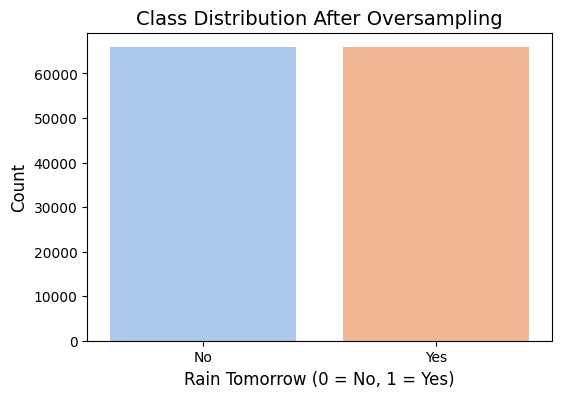

In [14]:
from sklearn.utils import resample

# --- Step 5: Oversampling and Handling Outliers on Training Data ---
print("\n--- Step 3: Oversampling and Handling Outliers on Training Data ---")
# Combine the scaled training features and the training labels into a single DataFrame.
df_train_combined = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
# Separate the majority (0) and minority (1) classes.
minority_class = df_train_combined[df_train_combined['RainTomorrow'] == 1]
majority_class = df_train_combined[df_train_combined['RainTomorrow'] == 0]

# Perform oversampling on the minority class.
if not minority_class.empty:
    # Resample the minority class with replacement to match the size of the majority class.
    minority_oversampled = resample(minority_class,
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=42)
    # Combine the resampled minority class with the original majority class.
    df_train_resampled = pd.concat([majority_class, minority_oversampled])
else:
    print("⚠️ Minority class is empty. Oversampling not performed.")
    df_train_resampled = df_train_combined.copy()

print("Class distribution after oversampling:\n", df_train_resampled['RainTomorrow'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train_resampled, x='RainTomorrow', hue='RainTomorrow', palette='pastel', legend=False)

plt.title("Class Distribution After Oversampling", fontsize=14)
plt.xlabel("Rain Tomorrow (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['No', 'Yes'])

plt.show()

In [15]:
# Outlier removal using the Interquartile Range (IQR) method.
features_to_clean = df_train_resampled.drop('RainTomorrow', axis=1)
Q1 = features_to_clean.quantile(0.25)
Q3 = features_to_clean.quantile(0.75)
IQR = Q3 - Q1
# Create a mask to identify rows with outliers.
outlier_mask = ((features_to_clean < (Q1 - 1.5 * IQR)) | (features_to_clean > (Q3 + 1.5 * IQR))).any(axis=1)
# Keep only the rows that are NOT outliers.
cleaned_resampled = df_train_resampled[~outlier_mask]

# Separate the final clean features and target for training.
X_train_final = cleaned_resampled.drop('RainTomorrow', axis=1)
y_train_final = cleaned_resampled['RainTomorrow']

print("Final shape after outlier removal:", cleaned_resampled.shape)
print("Final class distribution:\n", y_train_final.value_counts(normalize=True))

final_cleaned_data = pd.concat([X_train_final, y_train_final], axis=1)
print("\n--- Final Cleaned Training Dataset (Preview) ---")
final_cleaned_data.head()

Final shape after outlier removal: (103013, 21)
Final class distribution:
 RainTomorrow
0.0    0.561822
1.0    0.438178
Name: proportion, dtype: float64

--- Final Cleaned Training Dataset (Preview) ---


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2,0.098553,1.075629,-0.27977,0.652595,0.220493,-1.700321,0.197676,-1.550710,0.025917,0.869946,...,-1.145714,-1.000797,-0.213519,-0.497136,0.229074,1.468046,0.767738,1.224938,-0.541299,0.0
3,-0.304344,1.020181,-0.27977,-0.291837,0.645181,-0.207745,-0.246720,-0.887302,-0.405110,-1.624024,...,1.625590,-1.194324,0.731207,0.571186,-0.182168,-0.733883,-0.650594,1.182580,-0.541299,0.0
4,-2.396309,-1.045242,-0.27977,-0.183345,0.786743,-1.273871,0.716137,0.439515,0.241430,-0.150315,...,-0.779692,-1.726524,1.890643,1.639507,-1.342181,-1.886009,-1.540824,-0.991803,-0.541299,0.0
7,-0.164879,0.507291,-0.27977,-0.508822,-0.062633,-0.207745,1.160533,-0.223893,-0.189596,-0.150315,...,-1.302580,-1.339469,-0.328031,-0.424952,0.229074,0.629532,0.511231,0.660163,-0.541299,0.0
10,-1.342579,-0.851175,-0.27977,-0.605565,0.588556,-0.634196,-1.505842,-1.329574,-0.620623,-0.377039,...,-0.465960,-0.613742,1.890643,1.798311,-1.734994,-0.924871,-0.907101,-0.794132,-0.541299,0.0


In [16]:
import numpy as np

# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Derivative of sigmoid
def sigmoid_derivative(z):
    return z * (1 - z)

# Training a simple 2-layer NN
def train_nn(X, y, hidden_neurons=4, lr=0.01, epochs=1000):
    np.random.seed(42)
    n_samples, n_features = X.shape
    n_output = 1

    # Initialize weights
    W1 = np.random.randn(n_features, hidden_neurons)
    b1 = np.zeros((1, hidden_neurons))
    W2 = np.random.randn(hidden_neurons, n_output)
    b2 = np.zeros((1, n_output))

    for _ in range(epochs):
        # Forward pass
        z1 = np.dot(X, W1) + b1
        a1 = sigmoid(z1)

        z2 = np.dot(a1, W2) + b2
        a2 = sigmoid(z2)   # prediction

        # Compute error
        error = a2 - y

        # Backpropagation
        dW2 = np.dot(a1.T, (error * sigmoid_derivative(a2)))
        db2 = np.sum(error * sigmoid_derivative(a2), axis=0, keepdims=True)

        dW1 = np.dot(X.T, (np.dot(error * sigmoid_derivative(a2), W2.T) * sigmoid_derivative(a1)))
        db1 = np.sum(np.dot(error * sigmoid_derivative(a2), W2.T) * sigmoid_derivative(a1), axis=0, keepdims=True)

        # Update weights
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    return W1, b1, W2, b2

# Prediction
def predict_nn(X, W1, b1, W2, b2):
    a1 = sigmoid(np.dot(X, W1) + b1)
    a2 = sigmoid(np.dot(a1, W2) + b2)
    return (a2 >= 0.5).astype(int)
